In [1]:
!pip install gym

In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from blackjack_env import BlackjackEnv
from blackjack_env_double import BlackjackEnvDouble
from blackjack_env_double_deck import BlackjackEnvDoubleDeck
from service import calculate_reward, run_episode_actions, get_random_Q, init_C, compute_policy_by_Q, update_returns_actions_offpolicy_MC

In [3]:
number_of_test_episodes = 100000

# Simple strategy

In [4]:
env = BlackjackEnv(natural=True)
nS = (28, 10, 2) # 28 - number of possible card sums from 4 to 32, 10 - the dealer's one showing card, 2 - for usable ace
nA = 2 # number of possible actions
final_states = tuple(range(18, 28))
pi = np.ones(nS, dtype=np.int8)
pi[15:, :, :] = 0
print(f"Approximate avg reward: {round(calculate_reward(env, pi, episodes=number_of_test_episodes) / number_of_test_episodes, 4)}")

Approximate avg reward: -0.1786


In [5]:
full_training_episodes = 2000000
final_states = tuple(range(18, 28))

def run(nS, nA, env_done):
    gamma_grid = [0.7, 0.8, 0.9]
    eps_grid = [0.05, 0.1, 0.15, 0.2]
    total_episodes = number_of_test_episodes
    results = defaultdict(dict)

    for gamma in gamma_grid:
        for eps in eps_grid:
            print(f"Running for gamma: {gamma}, eps: {eps}")
            env = env_done
            Q = get_random_Q(nS, nA, final_states=final_states)
            pi = compute_policy_by_Q(Q, nS)
            C = init_C(nS, nA)
            training_rewards = []

            for _ in range(total_episodes):
                states, actions, rewards = run_episode_actions(env, pi, eps=eps, nA=nA)
                training_rewards.append(rewards[-1])
                Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, nA=nA, epsilon=eps, gamma=gamma)
                pi = compute_policy_by_Q(Q, nS)

            results[gamma][eps] = np.cumsum(training_rewards)
            env.close()
    
    fig, axs = plt.subplots(2, figsize=(10, 10))
    
    best_gamma = None
    best_value = -999999999
    for gamma, item in results.items():
        r_mean_trajectory = np.mean(np.array(list(item.values())), axis=0)
        if best_gamma is None or best_value < r_mean_trajectory[-1]:
            best_gamma = gamma
            best_value = r_mean_trajectory[-1]
        axs[0].plot(r_mean_trajectory, label=gamma)

    axs[0].set_xlabel("Episode")
    axs[0].set_ylabel("Rewards dynamics grouped by gamma")
    axs[0].legend(loc="lower left")

    best_eps = None
    best_value = -999999999
    for i, eps in enumerate(eps_grid):
        r_mean_trajectory = np.mean(np.array([list(item.values())[i] for item in results.values()]), axis=0)
        if best_eps is None or best_value < r_mean_trajectory[-1]:
            best_eps = eps
            best_value = r_mean_trajectory[-1]
        axs[1].plot(r_mean_trajectory, label=eps)

    axs[1].set_xlabel("Episode")
    axs[1].set_ylabel("Rewards dynamics grouped by eps")
    axs[1].legend(loc="lower left")
    plt.show()
    
    print(f"Best gamma: {best_gamma}, best eps: {best_eps}")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.plot(np.true_divide(results[best_gamma][best_eps], np.arange(1, len(results[best_gamma][best_eps]) + 1)))
    ax.set_xlabel("Episode")
    ax.set_ylabel("Avg Reward dynamics")
    plt.show()
    
    print(f"Approximate avg reward: {round(results[best_gamma][best_eps][-1] / len(results[best_gamma][best_eps]), 4)}")
    
    total_episodes = full_training_episodes

    env = env_done
    Q = get_random_Q(nS, nA, final_states=final_states)
    pi = compute_policy_by_Q(Q, nS)
    C = init_C(nS, nA)
    training_rewards = []

    for _ in tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, pi, eps=best_eps, nA=nA)
        training_rewards.append(rewards[-1])
        Q, C = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, nA=nA, epsilon=best_eps, gamma=best_gamma)
        pi = compute_policy_by_Q(Q, nS)

    env.close()
    
    print(f"Better trained approximate avg reward: {round(calculate_reward(env, pi, episodes=number_of_test_episodes) / number_of_test_episodes, 4)}")

# Monte-Carlo control

Running for gamma: 0.7, eps: 0.05
Running for gamma: 0.7, eps: 0.1
Running for gamma: 0.7, eps: 0.15
Running for gamma: 0.7, eps: 0.2
Running for gamma: 0.8, eps: 0.05
Running for gamma: 0.8, eps: 0.1
Running for gamma: 0.8, eps: 0.15
Running for gamma: 0.8, eps: 0.2
Running for gamma: 0.9, eps: 0.05
Running for gamma: 0.9, eps: 0.1
Running for gamma: 0.9, eps: 0.15
Running for gamma: 0.9, eps: 0.2


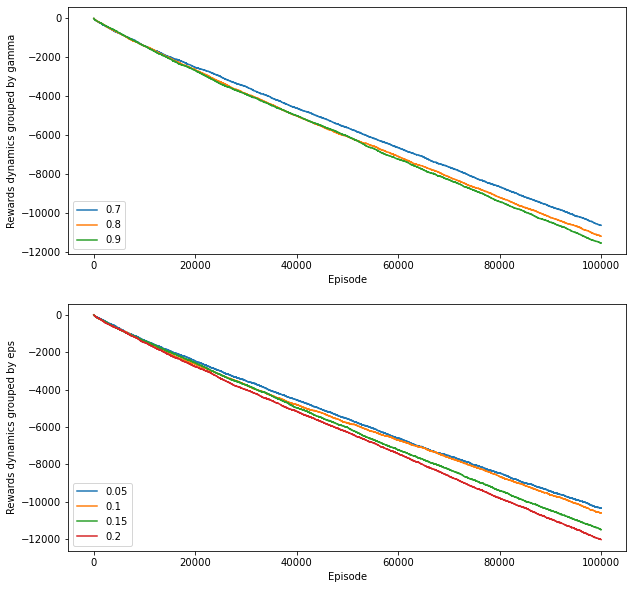

Best gamma: 0.7, best eps: 0.05


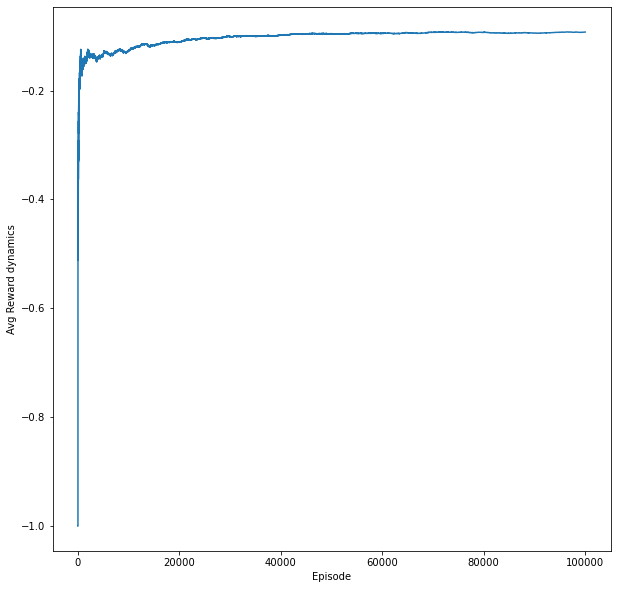

  0%|                                                                                      | 0/2000000 [00:00<?, ?it/s]

Approximate avg reward: -0.0926


100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [02:29<00:00, 13404.50it/s]


Better trained approximate avg reward: -0.0616


In [6]:
nS = (28, 10, 2)
nA = 2
run(nS, nA, BlackjackEnv(natural=True))

# Double

Running for gamma: 0.7, eps: 0.05
Running for gamma: 0.7, eps: 0.1
Running for gamma: 0.7, eps: 0.15
Running for gamma: 0.7, eps: 0.2
Running for gamma: 0.8, eps: 0.05
Running for gamma: 0.8, eps: 0.1
Running for gamma: 0.8, eps: 0.15
Running for gamma: 0.8, eps: 0.2
Running for gamma: 0.9, eps: 0.05
Running for gamma: 0.9, eps: 0.1
Running for gamma: 0.9, eps: 0.15
Running for gamma: 0.9, eps: 0.2


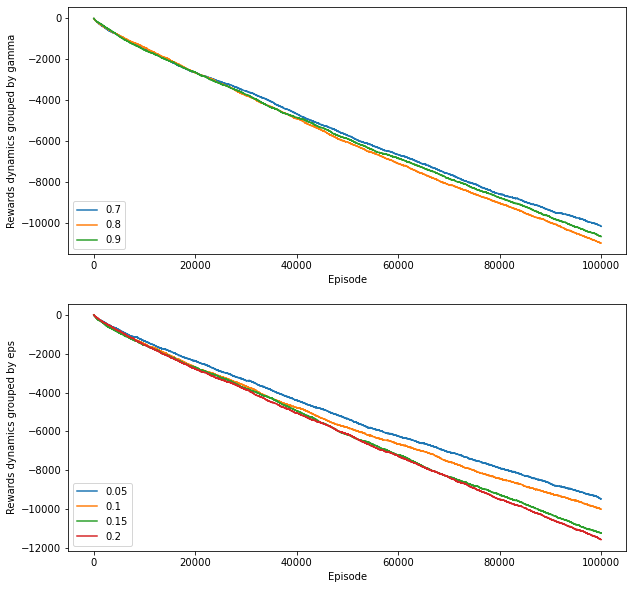

Best gamma: 0.7, best eps: 0.05


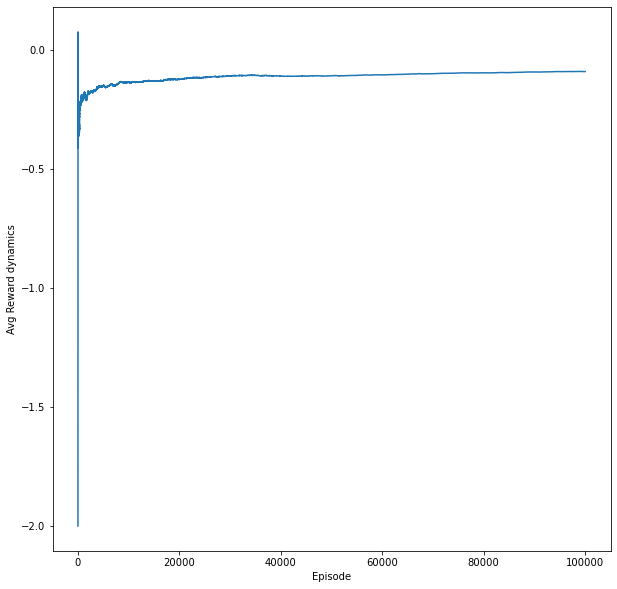

  0%|                                                                                      | 0/2000000 [00:00<?, ?it/s]

Approximate avg reward: -0.0924


100%|█████████████████████████████████████████████████████████████████████| 2000000/2000000 [02:31<00:00, 13218.70it/s]


Better trained approximate avg reward: -0.0401


In [7]:
nS = (28, 10, 2)
nA = 3 # adding another action for double
run(nS, nA, BlackjackEnvDouble(natural=True))

# Double and deck check

Running for gamma: 0.7, eps: 0.05
Running for gamma: 0.7, eps: 0.1
Running for gamma: 0.7, eps: 0.15
Running for gamma: 0.7, eps: 0.2
Running for gamma: 0.8, eps: 0.05
Running for gamma: 0.8, eps: 0.1
Running for gamma: 0.8, eps: 0.15
Running for gamma: 0.8, eps: 0.2
Running for gamma: 0.9, eps: 0.05
Running for gamma: 0.9, eps: 0.1
Running for gamma: 0.9, eps: 0.15
Running for gamma: 0.9, eps: 0.2


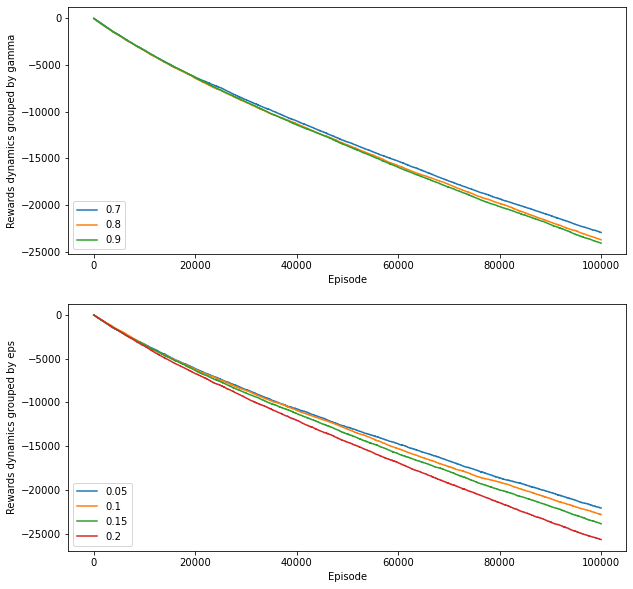

Best gamma: 0.7, best eps: 0.05


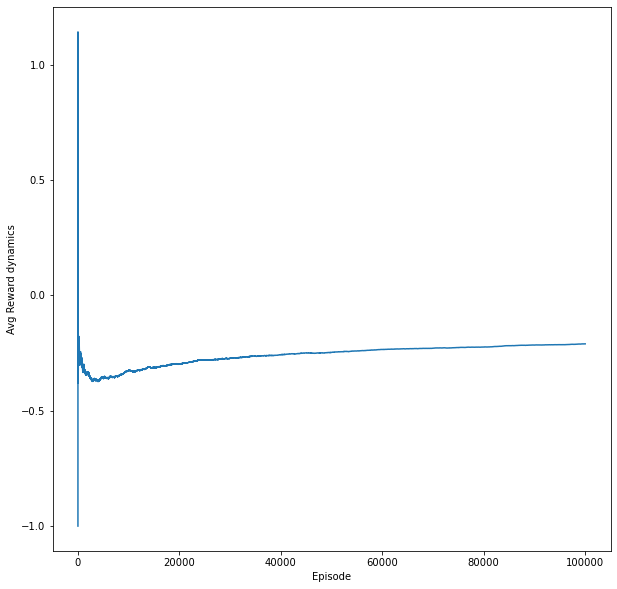

  0%|                                                                            | 96/2000000 [00:00<35:04, 950.50it/s]

Approximate avg reward: -0.2098


100%|██████████████████████████████████████████████████████████████████████| 2000000/2000000 [31:48<00:00, 1048.07it/s]


Better trained approximate avg reward: -0.0131


In [8]:
nS = (28, 10, 2, 65, 2) # 65 - possible values count for HI OPT 2 counting system
nA = 3
run(nS, nA, BlackjackEnvDoubleDeck(natural=True))

Как мы видим, обыграть казино весьма непросто, но мы практически вышли в 0